# <u>Chapter 3</u>: Topic Classification

Businesses deal with many other unstructured texts daily, like, news posts, support tickets, or customer reviews. Failing to glean this data efficiently can lead to missed opportunities or, even worse, angry customers. So again, an automated system that can process a vast amount of data is a more scalable solution than manual scanning.   In this exercise, we focus on the problem of `topic classification`, with the aim to assign a topic to some piece of text. The list of topics is predefined, and in that sense, we are still in the realm of supervised learning. For this task, we use the [20 newsgroups dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups) available through _scikit-learn_ and that comprises around 18000 newsgroups posts on 20 topics. We implement a topic classifier from scratch and present various techniques related to dimensionality reduction and text mining:

* **Exploratory data analysis**
    * Pie charts
    * N-gram frequencies
* **Dimensionality reduction**
    * Principal Component Analysis
    * Linear Discriminant Analysis
    * Singular Value Decomposition
* **Text representations**
    * Word Embedding
* **Classification algorithms**
    * K-Nearest Neighbor
    * Random Forest
    * Decision Trees
* **Tools**
    * fastText

You need a Google account to download: [GoogleNews-vectors-negative300.bin.gz](https://code.google.com/archive/p/word2vec/)

Then, place the file under: _./data_

In [ ]:
# Install the necessary modules.
%pip install matplotlib
%pip install sklearn
%pip install pandas
%pip install numpy
%pip install seaborn
%pip install gensim
%pip install fasttext

## Exploratory data analysis

As in every machine learning problem, we start with an exploratory data analysis. Before we start an in-depth analysis, we extract some basic information from the corpus. After importing the dataset, we can print the number of samples in it, the different categories of news posts, and the contents of one sample. As we can see from the output, the posts deal with diverse subjects like technology, politics, and religion, where their content consists of metadata (e.g. _From_, _Subject_) and the main body of the message.

In [2]:
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups

# Load the news data and print the names of the categories.
news = fetch_20newsgroups(subset='all')

# Print various information about the data.
print("Number of articles: " + str(len(news.data)))


Number of articles: 18846


In [3]:
print("Number of different categories: " + str(len(news.target_names)))

Number of different categories: 20


In [4]:
print(news.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [5]:
print("\n".join(news.data[6].split("\n")[:]))

From: lpa8921@tamuts.tamu.edu (Louis Paul Adams)
Subject: Re: Number for Applied Engineering
Organization: Texas A&M University, College Station
Lines: 9
NNTP-Posting-Host: tamuts.tamu.edu

>Anyone have a phone number for Applied Engineering so I can give them
>a call?


AE is in Dallas...try 214/241-6060 or 214/241-0055.  Tech support may be on
their own line, but one of these should get you started.

Good luck!




Using the code below, we create a pie chart, where each slice shows the percentage of each category in the dataset. We observe a balance in the number of samples per category looking at the figure. This is quite an important observation because we want to avoid categories that monopolize the data and might skew our analysis. If this were the case, we should simply use a subset for this category to balance it with others.

In [ ]:
import matplotlib.pyplot as plt

# Keep track of the number of samples per category.
samples_per_category = {}

# Iterate over all data.
for i in range(len(news.data)):
	# Get the category for the specific sample.
	category = news.target_names[news.target[i]]
	# Increase the category index by one.
	if category in samples_per_category:
		samples_per_category[category] += 1
	else:
		samples_per_category[category] = 1

# Create and show the distribution pie chart.
slices = []

# Obtain the slices of the pie.
for key in samples_per_category:
	slices.append(samples_per_category[key])

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(slices, labels=news.target_names, autopct='%1.1f%%', startangle=90)


Another helpful visualization is the frequency of bi-grams in each category, as it provides an immediate intuition whether or not they can be used for classifying the posts. For example, we calculate the thirty most frequent bi-grams for the _misc.forsale_ category. According to the histogram, few bi-grams seem relevant to this category, like _for sale_, _best offer_ and _to sale_. There are, of course, others that can equally appear to all categories.

<AxesSubplot:title={'center':'Bi-gram frequency chart'}, xlabel='Bi-gram'>

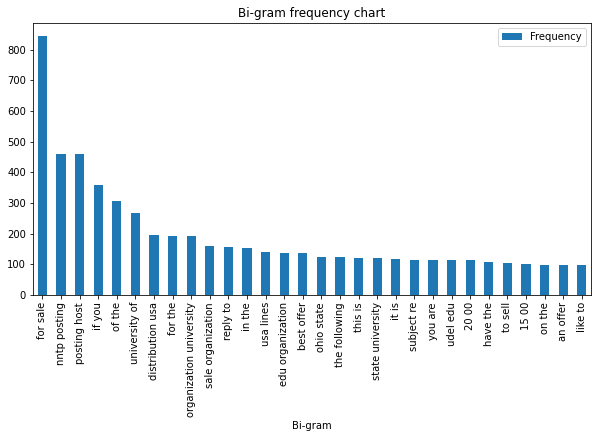

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Samples for the 'misc.forsale' category.
news_misc_forsale = []

# Iterate over all data.
for i in range(len(news.data)):
	# Get the samples.
	if news.target_names[news.target[i]] == 'misc.forsale':
		news_misc_forsale.append(news.data[i])

# Create the count vectorizer using bi-grams.
vectorizer = CountVectorizer(ngram_range=(2, 2))

# Fit and transform
x = vectorizer.fit_transform(news_misc_forsale)

# Get the 30 most frequent bigrams.
sum_words = x.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
words = words_freq[:30]

# Create and show the bar chart.
df = pd.DataFrame(words, columns=['Bi-gram', 'Frequency'])
df = df.set_index('Bi-gram')
df.plot(figsize=(10, 5), kind='bar', title='Bi-gram frequency chart')

## Dimensionality reduction

As part of the `EDA`, it could be helpful to visualize high-dimensional spaces into something our limited human brain can comprehend. In this way, we can identify patterns in the data and possible directions for analysis. Furthermore, there are situations in machine learning problems where redundant or highly correlated features can be removed from the subsequent analysis. For example, in a task for classifying planets, radius (_r_) and circumference (_2πr_) can be two of the features. However, as they are highly correlated, there is no extra gain including both in the feature space. So, we can either keep only one feature or introduce a new one that is a linear combination of radius and circumference. This process is called `dimensionality reduction` and it proves to be very helpful for speeding up the training of machine learning algorithms, filtering noise in the data, performing feature extraction, and data visualization. In general, working with fewer dimensions often makes analysis algorithms more efficient and can help machine learning algorithms offer more accurate predictions.

### Principal Component Analysis

One classic method of this kind is called `Principal Component Analysis` (PCA), which is an unsupervised learning method. This means that PCA tries to identify relations among the data samples without knowing the class each one belongs to. The method creates a new coordinate system with a new set of orthogonal axes (principal components); the first axis goes toward the highest variance  in the data, while the second one goes to the second-highest variance. For multidimensional data, more principal components can be calculated. PCA aims at keeping the maximum amount of variation (information) about how the original data is distributed, so bear in mind that a certain level of information is lost during the process. 

After calculating the three components, the output is shown in the figure. It is evident that _PC1_ captures the most variation, which is reduced as we move down in order (_PC2_ and _PC3_).

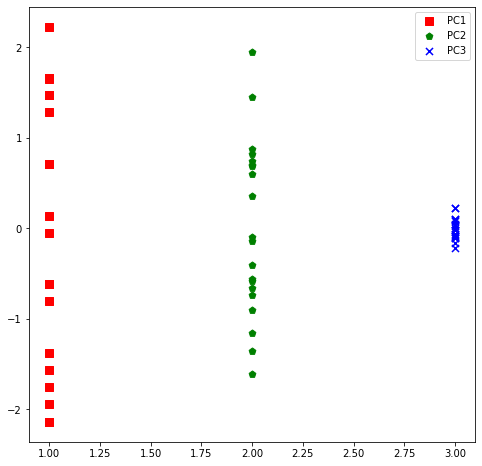

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Our random data points.
points = np.array([[0.1,0.1,0.1], [0.2,0,0.2], [0.3,-0.1,0.3],
                    [0.4,-0.1,0.4], [-0.1,0.1,-0.1], [-0.2,0,-0.2],
                    [-0.3,0.1,-0.3], [-0.4,0,-0.4], [-0.5,0.1,-0.5],
                    [0.2,0,0.1], [0.3,0.1,0.2], [0.4,-0.1,0.5],
                    [0.5,0.1,0.4], [0.5,0,0.6], [0.3,-0.1,0.4],
                    [-0.2,-0.1,-0.1], [-0.4,0.1,-0.3], [-0.2,0.1,-0.3],
                    [-0.6,-0.1,-0.5], [-0.5,0,-0.4]])	
			
# Standardize the points.
spoints = StandardScaler().fit_transform(points)

# Calculate 3 principal components.
pca = PCA(n_components=3)
pcaComponents = pca.fit_transform(spoints)

# Generate the scatter plot.
x1 = [1]*20
x2 = [2]*20
x3 = [3]*20

# Plot the figure.
pcaFigure = plt.figure(figsize=(8, 8))
pcaAxes = pcaFigure.add_subplot(1, 1, 1) 
pcaAxes.scatter(x1, pcaComponents[:,0], s=50, c='r', marker="s", label='PC1')
pcaAxes.scatter(x2, pcaComponents[:,1], s=50, c='g', marker="p", label='PC2')
pcaAxes.scatter(x3, pcaComponents[:,2], s=50, c='b', marker="x", label='PC3')
plt.legend(loc='upper right')


At the beginning of the section, we have mentioned that each principal component captures part of the variance in a certain direction. But how can we quantify this, and when can we be certain that enough variance has been considered? For example, the code below shows that the first component contains 69.9% of the variance, the second 29.6%, and the third 0.004%. A rule of thumb, in this case, is that the first and second principal components should capture at least 85% of the variance to expect some helpful insight into the data when examining the generated plot. So the percentage in our case is acceptable.

In [9]:
# Show the variance ratio per principal component.
pca.explained_variance_ratio_

array([0.69943775, 0.29606821, 0.00449403])

We are now ready to draw the plot of our data points on the new coordinate system. The points now occupy a new position, with similar ones being closer. Look, for example, at the cluster with the samples 3, 4, 12, and 15. Another interesting observation is that there are three trend lines for the data points. The samples that belong to each line have the same value in their _y_ coordinate. E.g. the points 2, 6, 8, 10, 14, and 20.

C:\Users\tsouraki\AppData\Local\Temp/ipykernel_9576/333879479.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pcaFigure.show()


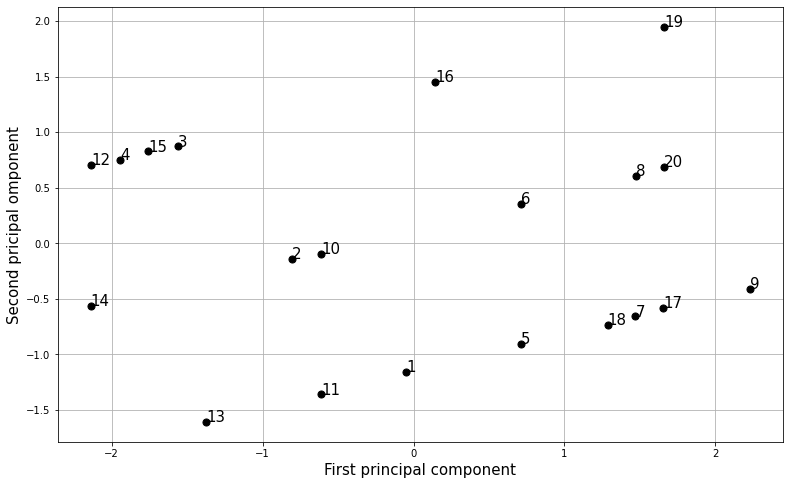

In [10]:
# Create a data frame out of the principal components.
pcaFrame = pd.DataFrame(data = pcaComponents, 
                        columns = ['principal component 1', 
                        'principal component 2', 'principal component 3'])
		
# Generate the scatter plot.	
pcaFigure = plt.figure(figsize=(13, 8))
pcaAxes = pcaFigure.add_subplot(1, 1, 1) 
pcaAxes.set_xlabel('First principal component', fontsize=15)
pcaAxes.set_ylabel('Second pricipal omponent', fontsize=15)

pcaAxes.scatter(pcaFrame.loc[:, 'principal component 1'],
                pcaFrame.loc[:, 'principal component 2'],
                c='black', s=50)

# Add the index of each point to the plot.
index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
         11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
			   
for i, txt in enumerate(index):
    pcaAxes.annotate(txt, (pcaFrame.loc[i, 'principal component 1'],
                    pcaFrame.loc[i, 'principal component 2']), fontsize=15)

pcaAxes.grid()
pcaFigure.show()


Going a step further, it is logical to think that if a few sets of principal components can visualize the data, these can also be used as new features. The idea behind feature extraction under PCA is that the new feature values can express the data samples as a weighted sum of the principal components. In practice, PCA reduces the initial number of features in ML problems and can lead to simpler and more accurate classification models.

### Linear Discriminant Analysis

Another well-known dimensionality reduction algorithm is the `Linear Discriminant Analysis` (LDA). While PCA is an unsupervised algorithm focusing on identifying the combination of principal components that maximize variance in a dataset, LDA is a supervised algorithm to maximize separability between different classes.

### PCA and LDA in action

Let’s apply our knowledge about PCA and LDA in the _20 newsgroups_ dataset. Both techniques will be used to visualize the data. From the output, we observe that data points of similar categories appear to cluster closer. This is quite amazing as only two principal components were used.

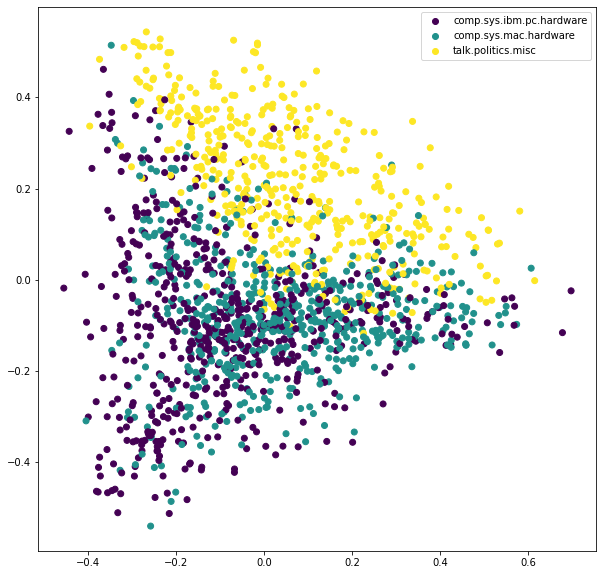

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

# Select one of the following three categories.
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'talk.politics.misc']
#categories = ['alt.atheism', 'comp.windows.x', 'talk.religion.misc']
#categories = ['rec.sport.baseball', 'rec.sport.hockey', 'sci.space']
#categories = ['rec.autos', 'rec.motorcycles', 'talk.politics.guns']

# Load the news data only for the specific categories.
news = fetch_20newsgroups(categories=categories)

# Keep a smaller portion of the data.
data_samples = news.data[:2000]
data_target = news.target[:2000]

# Create the tf-idf vectorizer.
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=100, stop_words='english')

# Generate the tf-idf matrix for the datamset.
tfidf = vectorizer.fit_transform(data_samples)
	
# Calculate 2 principal components.
pca = PCA(n_components=2)
pcaComponents = pca.fit_transform(tfidf.toarray())

# Create and show the plot.
plt.figure(figsize=(10, 10))
scatter = plt.scatter(pcaComponents[:,0], pcaComponents[:,1], c=data_target)
labels = np.unique(data_target)
handles = [plt.Line2D([],[], marker="o", ls="", color=scatter.cmap(scatter.norm(i))) for i in labels]
plt.legend(handles, categories)

Let’s try using LDA now for the same task. As before, two principal components are used, and the output is presented in the figure. We observe this time that the separation of classes is much better and with minimum overlap.

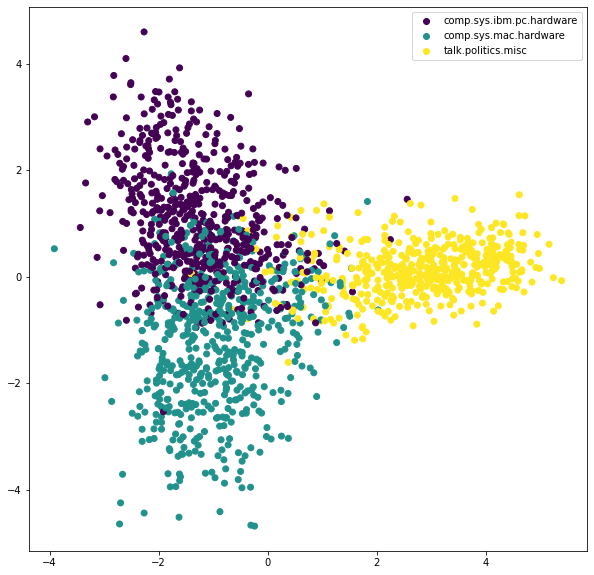

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Calculate 2 principal components.
lda = LinearDiscriminantAnalysis(n_components=2)
ldaComponents = lda.fit(tfidf.toarray(), data_target)
ldaComponents = lda.transform(tfidf.toarray())

# Create and show the plot.
plt.figure(figsize=(10, 10))
scatter = plt.scatter(ldaComponents[:,0], ldaComponents[:,1], c=data_target)
labels = np.unique(data_target)
handles = [plt.Line2D([], [], marker="o", ls="", color=scatter.cmap(scatter.norm(i))) for i in labels]
plt.legend(handles, categories)


We can also obtain the ten top words per news category. Interestingly, the output includes words like “_card_”, “_ide_”, “_bus_” for _comp.sys.ibm.pc.hardware_, “_apple_”, “_mac_” for _comp.sys.mac.hardware_ and “_government_”, “_clinton_" for _talk.politics.misc_.

In [13]:
# Print the 10 top words per news category.
feature_names = np.asarray(vectorizer.get_feature_names())
for i, category in enumerate(categories):
    top = np.argsort(lda.coef_[i])[-10:]
    print("%s: %s" % (category, " ".join(feature_names[top])))

comp.sys.ibm.pc.hardware: os program card help ide bus pc dos windows host
comp.sys.mac.hardware: monitor ram work speed got software thanks apple mac nntp
talk.politics.misc: said say did people cramer writes stephanopoulos government clinton nntp


## K-Nearest Neighbor

The `K-Nearest Neighbor` (KNN) algorithm is a nonparametric and lazy learning algorithm that stores the position of all data samples and classifies new cases based on some similarity measure. Lazy learning means that the algorithm takes almost zero time to learn, and in the case of KNN, the training samples are simply stored and used to classify new samples. Then, a majority vote of its neighbors classifies each sample. 

We start by creating the training and test sets.

In [14]:
# Select the following five categories.
categories = ['alt.atheism', 'comp.graphics', 'misc.forsale', 'rec.autos', 'sci.crypt']
 
# Load data only for the specific categories.
train_data = fetch_20newsgroups(subset='train', categories=categories, random_state=123)
test_data = fetch_20newsgroups(subset='test', categories=categories, random_state=123)

# Create the tf-idf vectorizer.
vectorizer = TfidfVectorizer(stop_words='english')

# Generate the tf-idf matrix for the two sets.
tfidf_train = vectorizer.fit_transform(train_data.data)
tfidf_test = vectorizer.transform(test_data.data)

# Print the shape of the sets.
print(tfidf_train.shape)

(2838, 39828)


In [15]:
print(tfidf_test.shape)

(1890, 39828)


To use KNN, we need to choose a value for the hyperparameter _K_. The question now is what this value should be. Hopefully, there is a technique to help us in this situation that is called `Cross-Validation`. There are three basic steps: (1) initially we partition the data into several subsets (folds), (2) each time we hold out one of these subsets and train the model with the rest, and (3) we evaluate the model with the holdout test. There are different types of cross-validation, and `k-Fold` is one of those. The code below shows an example for the 5-Fold cross-validation case.

In [16]:
import scipy.sparse as sp
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# List of possible number of neighbors.
neighbors_values = list(range(1, 100))

# List of the mean scores.
mean_scores = []

# Perform 10-fold cross-validation.
for k in neighbors_values:
    
    # Create the classifier
    classifier = KNeighborsClassifier(n_neighbors=k)
    
    # Obtain the cross-validation scores.
    scores = cross_val_score(classifier, tfidf_train, train_data.target, cv=10, scoring='accuracy')
    
    # Store the mean value of the scores.
    mean_scores.append(scores.mean())
     
    # Calculate the errors.
    errors = [1 - x for x in mean_scores]
    
    # Obtain the best value for the hyperparameter.
    best_value = neighbors_values[errors.index(min(errors))]

# Print the best value for the hyperparameter.
print(best_value)

94


Using this value for _K_=94 we can proceed on training the KNN model on the whole training set and evaluate it on the test one. According to the output, the accuracy is around 90.5%, which is quite a decent result.

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create the classifier.
knn_classifier = KNeighborsClassifier(n_neighbors=94)

# Fit the classifier with the train data.
knn_classifier.fit(tfidf_train, train_data.target)

# Get the predicted classes.
test_class_pred = knn_classifier.predict(tfidf_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_data.target, test_class_pred)

0.9052910052910053

We also print the confusion matrix that can provide a better intuition on the strengths and weaknesses of the model. As we can observe, the highest numbers appear in the main diagonal, and ideally, we prefer everything else to be zero. For example, 24 of the _misc.forsale_ posts were mistakenly classified as _rec.autos_ ones. This is not very surprising, as one might expect that sale posts can also refer to automobiles. 

Text(0.5, 24.0, 'Predicted')

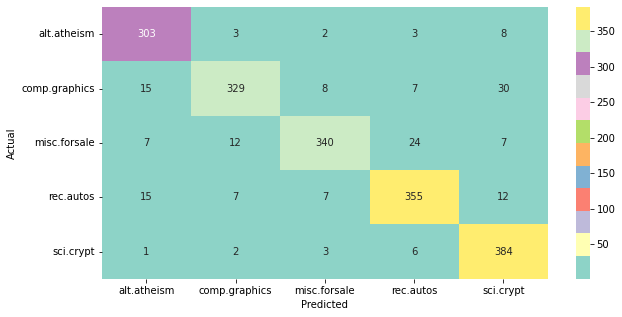

In [18]:
# Create the confusion matrix.
cm = confusion_matrix(test_data.target, test_class_pred)

# Plot confusion_matrix.
fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(cm, annot=True, cmap="Set3", fmt="d", xticklabels=categories, yticklabels=categories)
ax.set_yticklabels(categories, rotation=0)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Another thing we can try is to remove the metadata from each sample and calculate the new model’s accuracy. It seems logical to think that headers like "_From_", _"Subject"_, etc. do not contribute much to the classification task. The accuracy drops significantly to 21%. In the previous run, the algorithm could simply learn from the metadata. Perhaps certain keywords in the subject, the presence or absence of certain headers, etc. proved to be an important source of knowledge that was lost in the second run.

In [19]:
# Load data only for the specific categories.
train_data = fetch_20newsgroups(subset='train', categories=categories, random_state=123, remove=('headers', 'footers', 'quotes'))
test_data = fetch_20newsgroups(subset='test', categories=categories, random_state=123, remove=('headers', 'footers', 'quotes'))

# Create the tf-idf vectorizer.
vectorizer = TfidfVectorizer(stop_words='english')

# Generate the tf-idf matrix for the two sets.
tfidf_train = vectorizer.fit_transform(train_data.data)
tfidf_test = vectorizer.transform(test_data.data)

# Fit the classifier with the train data.
knn_classifier.fit(tfidf_train, train_data.target)

# Get the predicted classes.
test_class_pred = knn_classifier.predict(tfidf_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_data.target, test_class_pred)

0.20952380952380953

Baseline model

In [95]:
samples_per_category

{'rec.sport.hockey': 999,
 'comp.sys.ibm.pc.hardware': 982,
 'talk.politics.mideast': 940,
 'comp.sys.mac.hardware': 963,
 'sci.electronics': 984,
 'talk.religion.misc': 628,
 'sci.crypt': 991,
 'sci.med': 990,
 'alt.atheism': 799,
 'rec.motorcycles': 996,
 'rec.autos': 990,
 'comp.windows.x': 988,
 'comp.graphics': 973,
 'sci.space': 987,
 'talk.politics.guns': 910,
 'misc.forsale': 975,
 'rec.sport.baseball': 994,
 'talk.politics.misc': 775,
 'comp.os.ms-windows.misc': 985,
 'soc.religion.christian': 997}

In [21]:
len(fetch_20newsgroups(subset='train', categories=['sci.crypt']).data)

595

In [22]:
len(fetch_20newsgroups(subset='test', categories=['sci.crypt']).data)

396

## Random Forest

The `Random forest` method exploits the benefits of ensemble learning by constructing a multitude of `decision trees` on randomly selected data samples. Each one of those produces its own prediction, and the method is responsible for choosing the best one by means of voting. For example, the code shown below uses the dataset after removing any header. In this case, accuracy reaches 80%, which is astonishingly better than the result using KNN.

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Create the classifier.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=123)

# Fit the classifier with the train data.
rf_classifier.fit(tfidf_train, train_data.target)

# Get the predicted classes.
test_class_pred = rf_classifier.predict(tfidf_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_data.target, test_class_pred)

0.8

Coming back to the discussion about dimensionality reduction, it makes sense to apply it in our classification problem. Instead of using all available features, we can try to introduce a smaller set of features. One common technique for this task is the `Singular Value Decomposition` (SVD), which efficiently works with sparse matrices (frequently encountered in text classification). 

Two hundred components are chosen as output for the SVD that will be used as features by the random forest classifier.

In [24]:
from sklearn.decomposition import TruncatedSVD

# Load data only for the specific categories.
train_data = fetch_20newsgroups(subset='train', categories=categories, random_state=123)
test_data = fetch_20newsgroups(subset='test', categories=categories, random_state=123)

# Generate the tf-idf matrix for the two sets.
tfidf_train = vectorizer.fit_transform(train_data.data)
tfidf_test = vectorizer.transform(test_data.data)

# Calculate 200 components for the train and test sets.
svd = TruncatedSVD(n_components=200, algorithm='randomized', n_iter=5, random_state=123, tol=0.0)

svdComponents_train = svd.fit_transform(tfidf_train.toarray())
svdComponents_test = svd.transform(tfidf_test.toarray())

print(svdComponents_train.shape)

(2838, 200)


We can also plot the percentage of the cumulative variance for the different number of components in SVD. For example, the 200 components capture around 30% of the variance in the dataset, as shown in the figure.

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

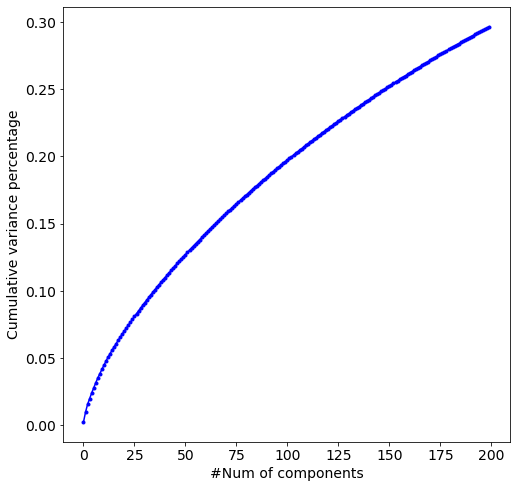

In [25]:
# Plot the cumulative variance percentage.
explained = svd.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8, 8))
plt.plot(explained, '.-', ms=6, color='b')
plt.xlabel('#Num of components', fontsize= 14)
plt.ylabel('Cumulative variance percentage', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In this case the accuracy of the classifier is around 90%.

In [26]:
# Fit the classifier with the train data.
rf_classifier.fit(svdComponents_train, train_data.target)

# Get the predicted classes.
test_class_pred = rf_classifier.predict(svdComponents_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_data.target, test_class_pred)

0.9047619047619048

Surprisingly, we obtain the same accuracy as the one for KNN when using _n_components=10_ in the same example. This suggests that the classification performance is the same with a much smaller set of features, and this model is preferable to the one for KNN. In general, there might be a number of possible and more complex alternatives for solving a particular problem. However, precedence should be given to simplicity; the simpler explanation of a problem should be preferred between two competing theories. This principle is called `Occam’s razor` and finds application in every field of life.

In [27]:
# Calculate 10 components for the train and test sets.
svd = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=5, random_state=123, tol=0.0)

svdComponents_train = svd.fit_transform(tfidf_train.toarray())
svdComponents_test = svd.transform(tfidf_test.toarray())

# Fit the classifier with the train data.
knn_classifier.fit(svdComponents_train, train_data.target)

# Get the predicted classes.
test_class_pred = knn_classifier.predict(svdComponents_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_data.target, test_class_pred)

0.891005291005291

## Word embedding

You are asked to create the matching algorithm for a new dating service. After registering to the system, your potential users will be asked a series of questions crafted to assess their five personality traits: extraversion, agreeableness, openness, conscientiousness, and neuroticism. A specific percentage will be assigned to each individual trait (black:0% and white:100%).

![Grayscale vectors of personality traits](https://github.com/PacktPublishing/Machine-Learning-Techniques-for-Text/ch3/images/dating.png)

The code below translates grayscale percentages into real numerical values and calculates the cosine similarity between the vectors. The output of this process proves us correct. The fourth candidate has the highest cosine similarity with the user understudy indeed. Therefore, our dating application can now suggest their profile to the user.

In [28]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Create the data for our user and the candidate profiles.
user = np.array([[0.41, 0.22, 0.85, 0.08, 0.98]])
candidates = np.matrix([[0.2, 0.93, 0.83, 0.39, 0.19],
                        [0.89, 0.87, 0.7, 0.18, 0.25],
                        [0.72, 0.03, 0.05, 0.82, 0.06],
                        [0.43, 0.78, 0.79, 0.02, 0.86],
                        [0.02, 0.03, 0.71, 0.39, 0.42]])

# Calculate and print the cosine similarity.
for candidate in candidates:
	print(cosine_similarity(user, candidate))

[[0.65631656]]
[[0.69953423]]
[[0.31021596]]
[[0.91916887]]
[[0.84170647]]


If you have grasped the reasoning behind the previous example, it should be straightforward to understand the word embedding representation. Like the five traits represent each person as a unique point in a 5-dimensional space, `word embedding` represents words in a multidimensional space, typically on the order of hundreds. 

![Embedding vector of various English words](https://github.com/PacktPublishing/Machine-Learning-Techniques-for-Text/ch3/images/word-emdedding.png)

Following the same approach as before, we show the embedding vector of various English words in the figure below. Each vector consists of 20 grayscale values, artificially constructed to provide some intuition on the subject. Take a look, for example, at the words for countries. They differ in all dimensions except for the 13th one. In the same manner, capital names match on the 3rd dimension, humans on the 9th (the dimension of humanity), boys and girls on the 9th and 6th (presumably the dimension of youth), and king and queen on the 9th and 17th (perhaps the dimension of royalty). So, word embedding is not just a way to numerically represent textual data but also a way to identify relations between words. This representation can lead to more powerful machine learning models by encapsulating their linguistic meaning. This is the reason why word embedding representations have gained a predominant role during the last few years.

The `genism` module allows us to use word embedding. We will also need to download pre-trained word embedding and _GoogleNews-vectors-negative300.bin.gz_  is one of the many different options. Notice that according to your system configuration it might take several minutes to load and execute the package. In the example beloq, we perform the vector arithmetic presented earlier and obtain the expected results.

In [29]:
from gensim.models import KeyedVectors

# Load the Word2Vec model.
model = KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin.gz', binary=True)

# Perform various word vector arithmetics.
model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

[('queen', 0.7118191123008728)]

In [30]:
model.most_similar(positive=['germany', 'paris'], negative=['france'], topn=1)

[('berlin', 0.48413652181625366)]

In [31]:
model.most_similar(positive=['play', 'walked'], negative=['walk'], topn=1)

[('played', 0.6983101963996887)]

In [32]:
model.most_similar(positive=['mother', 'doctor'], negative=['father'], topn=1)

[('nurse', 0.712788999080658)]

In [49]:
model.most_similar(positive=['she', 'architect'], negative=['he'], topn=1)

[('electrical_engineer', 0.5435980558395386)]

In [34]:
model.most_similar(positive=['woman', 'professor'], negative=['man'], topn=1)

[('associate_professor', 0.7771056294441223)]

In [77]:
model.most_similar(positive=['woman', 'schoolteacher'], negative=['man'], topn=1)

[('housewife', 0.6688467264175415)]

In [88]:
model.most_similar(positive=['woman', 'author'], negative=['man'], topn=1)

[('coauthor', 0.6184343695640564)]

In [94]:
model.most_similar(positive=['man', 'psychologist'], negative=['woman'], topn=1)

[('psychiatrist', 0.639894962310791)]

### Classification

It’s about time to use this form of textual representation for classification. In the following example, we iterate over all training samples, calculating each word’s vector in the sample. The word embedding for each sample is an average value of each word’s embedding. The same process is repeated for the test set.

In [30]:
import re

def get_word_vector(sample):
 
    wv = np.zeros(300) # Word vector.
    n = 0 # Number of words that have a word vector.
    
    # Iterate over all words in the sample.
    for word in re.sub('\\(|\\)|\n|\t|  |,|\.|\?|/|=|\"', "", sample).split(" "):
        
        # The word might not be present in the model.
        if word.lower() in model:
            wv = np.add(wv, model[word.lower()])
            n += 1

    if n == 0: # Use a dummy word.
        wv = np.add(wv, model["empty"])
    else: # Get an average value by dividing with n.
        wv = np.divide(wv, n)

    return wv
        
def get_word_vect_from_data(input):

    # Word vectors of the samples.
    wv_vect = []

    # Iterate through the data.
    for sample in input:
    
        # Get the word vector.
        wv = get_word_vector(sample)

        # Store the result for the sample.
        wv_vect.append(wv)

    return wv_vect

# Get the word vectors for the training and test data.   
wv_train = get_word_vect_from_data(train_data.data)
wv_test = get_word_vect_from_data(test_data.data)

As before, we use the `Random Forest` as our classifier, which yields a performance of around 82%.

In [31]:
# Fit the classifier with the train data.
rf_classifier.fit(wv_train, train_data.target)

# Get the predicted classes.
test_class_pred = rf_classifier.predict(wv_test)

# Calculate the accuracy on the test set.
metrics.accuracy_score(test_data.target, test_class_pred)

0.8222222222222222

## fastText

Let’s now examine another tool that offers pre-trained word embedding models. [fastText](https://fasttext.cc/) is an open-source tool created by Facebook for text representation and classification. We utilize the same training and test set, which were restructured to the form expected by the tool. After engaging the fastText supervised classifier, a similar accuracy is obtained. It seems that we cannot surpass this threshold, but you are strongly urged to test different configurations of the algorithms presented.

In [32]:
import fasttext

# Read and clean the data.
fasttext_train_data = [re.sub('\\(|\\)|\n|\t|  |,|\.|\?|/|=|\"', "", sample) for sample in train_data.data]
fasttext_test_data = [re.sub('\\(|\\)|\n|\t|  |,|\.|\?|/|=|\"', "", sample) for sample in test_data.data]

# Read and change the class labels.
fasttext_train_target = [("__label__" + str(sample) + " ") for sample in train_data.target]
fasttext_test_target = [("__label__" + str(sample) + " ") for sample in test_data.target]

# Element wise concatanation of the two lists.
fasttext_train = [i + j for i, j in zip(fasttext_train_target, fasttext_train_data)] 

# Print a sample.
fasttext_train[0]

'__label__2 From: AGRGB@ASUACADBITNETSubject: Re: CDs priced for immediate saleArticle-ID: ASUACAD93096004253AGRGBOrganization: Arizona State UniversityLines: 10Hey nowThe following cds are still available Offerstrades consideredGowan - Lost BrotherhoodKatrina & the Waves - Break of HeartsJoe Cocker - LiveCharles Neville - DiversityThanksRich'

In [33]:
# Write the data into a file.
with open('./data/fasttext.train', 'w') as f:
    for item in fasttext_train:
        f.write("%s\n" % item)
		
# Train the model.
fs_model = fasttext.train_supervised(input="./data/fasttext.train", lr=1.0, epoch=100)

# Get the predictions using the test data.
predictions = fs_model.predict(fasttext_test_data) 

# Assess the model.
fasttext_test_target_pred = [(label[0] + " ") for label in predictions[:][0]]
metrics.accuracy_score(fasttext_test_target, fasttext_test_target_pred)

0.8952380952380953

### Machine Learning Techniques for Text 
&copy;2021&ndash;2022, Nikos Tsourakis, <nikos@tsourakis.net>, Packt Publications. All Rights Reserved.